# NEAT + NSGA-II Analysis for Ms. Pac-Man Evolution

This notebook analyses the results of using NEAT combined with NSGA-II multi-objective optimisation to evolve neural networks for playing Ms. Pac-Man.

## Goals
- Evaluate the performance of NEAT in combination with NSGA-II for evolving neural network structures and weights
- Analyse how network topology evolves and impacts game score
- Assess NEAT's effectiveness in creating efficient neural networks with fewer parameters

In [1]:
## Imports and setup

import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from matplotlib.colors import LinearSegmentedColormap
import os
import warnings
warnings.filterwarnings('ignore')

# Load the results
with open('neat_final_results.pkl', 'rb') as f:
    results = pickle.load(f)

In [2]:
## Exploring the results structure

# Check the keys in the results dictionary
if 'results' in locals():
    print("Top-level keys in results dictionary:")
    for key in results.keys():
        print(f"- {key}")
        
    # Check generation_history
    if 'generation_history' in results:
        print("\nStructure of generation_history item:")
        if results['generation_history']:
            example_gen = results['generation_history'][0]
            for key in example_gen.keys():
                print(f"- {key}: {type(example_gen[key])}")

Top-level keys in results dictionary:
- generation_history
- elite_pool
- absolute_best_genomes
- final_islands
- best_population
- best_species
- config
- best_score
- diversity_metrics
- best_ever
- best_agents_summary

Structure of generation_history item:
- generation: <class 'int'>
- avg_score: <class 'numpy.float64'>
- max_score: <class 'float'>
- island_scores: <class 'list'>
- island_stagnation: <class 'list'>
- num_islands: <class 'int'>
- objective_stats: <class 'dict'>


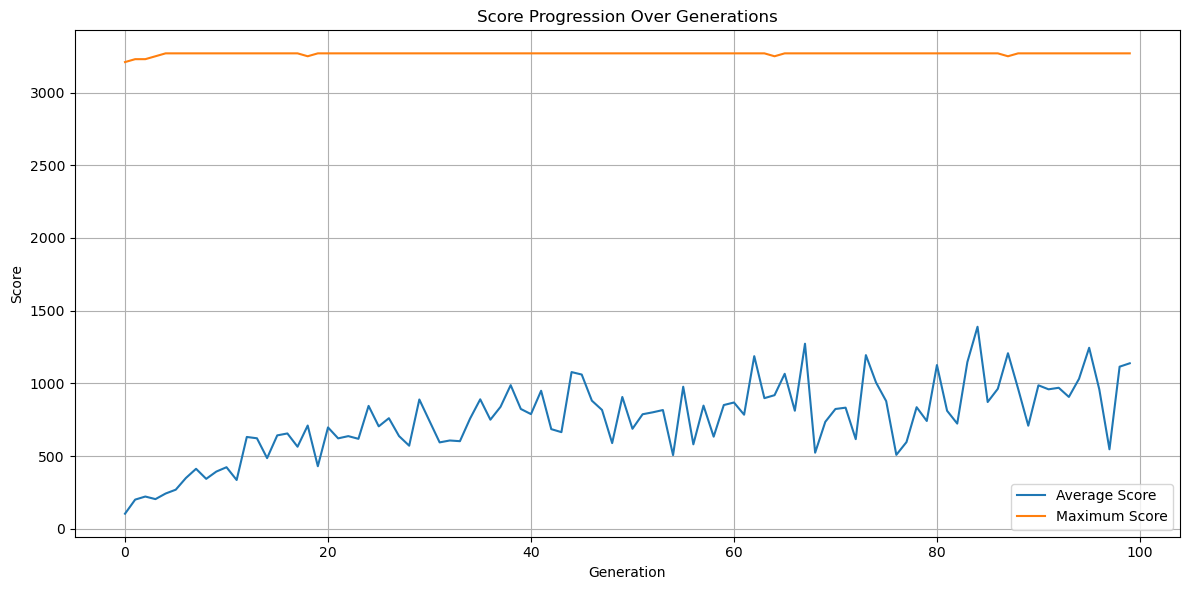

Score Progression Summary:
Initial Average Score: 103.33
Final Average Score: 1138.04
Improvement Factor: 11.01x
Initial Maximum Score: 3210.00
Final Maximum Score: 3270.00
Improvement Factor: 1.02x


In [3]:
# Analyse Performance Over Generations

# Score Progression
if 'generation_history' in results:
    # Extract data for plotting
    generations = [gen['generation'] for gen in results['generation_history']]
    avg_scores = [gen['avg_score'] for gen in results['generation_history']]
    max_scores = [gen['max_score'] for gen in results['generation_history']]
    
    # Create a DataFrame for easier plotting
    scores_df = pd.DataFrame({
        'Generation': generations,
        'Average Score': avg_scores,
        'Maximum Score': max_scores
    })
    
    # Plot score progression
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=scores_df, x='Generation', y='Average Score', label='Average Score')
    sns.lineplot(data=scores_df, x='Generation', y='Maximum Score', label='Maximum Score')
    plt.title('Score Progression Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("Score Progression Summary:")
    print(f"Initial Average Score: {avg_scores[0]:.2f}")
    print(f"Final Average Score: {avg_scores[-1]:.2f}")
    print(f"Improvement Factor: {avg_scores[-1]/max(1, avg_scores[0]):.2f}x")
    print(f"Initial Maximum Score: {max_scores[0]:.2f}")
    print(f"Final Maximum Score: {max_scores[-1]:.2f}")
    print(f"Improvement Factor: {max_scores[-1]/max(1, max_scores[0]):.2f}x")

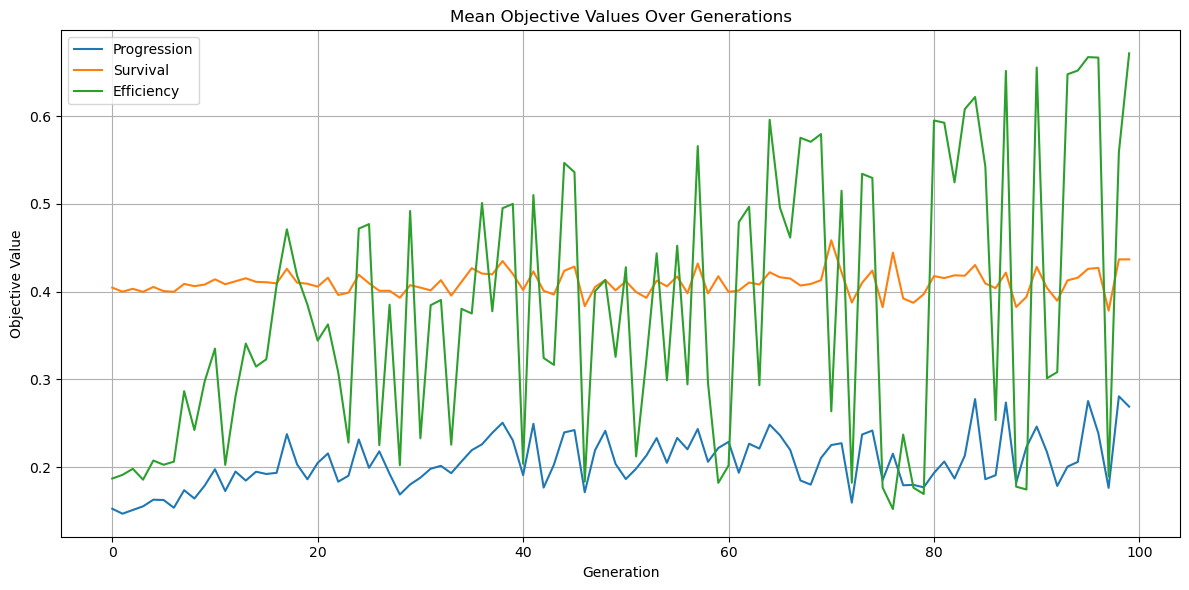

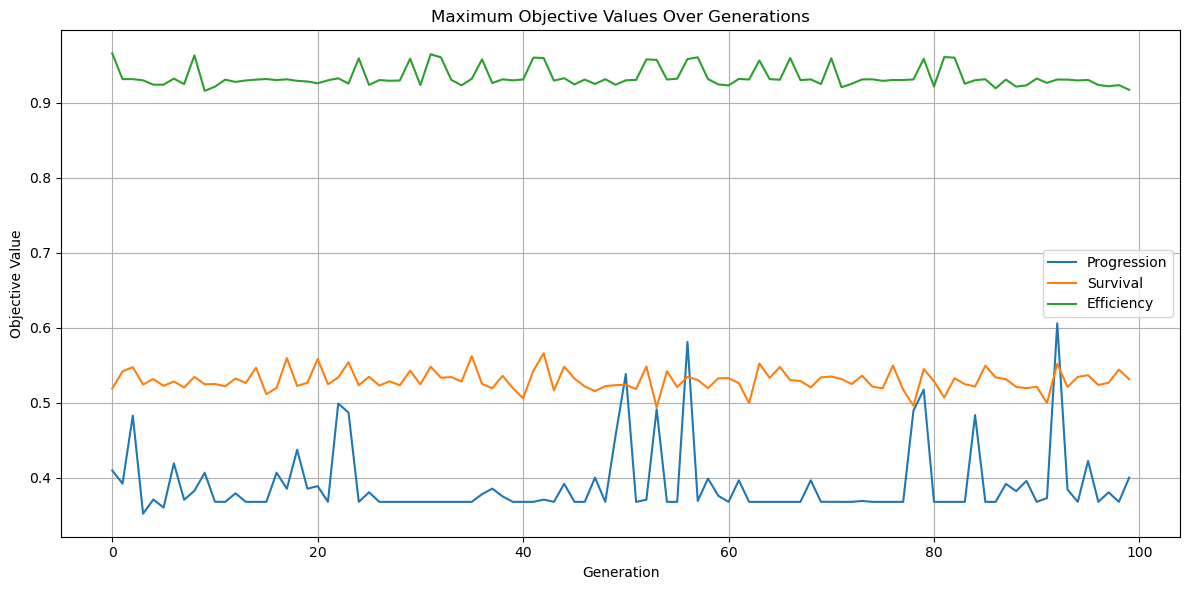

In [4]:
### Objective Values Progression

if 'generation_history' in results and 'objective_stats' in results['generation_history'][0]:
    # Create lists to hold the data
    progression_mean = []
    progression_max = []
    survival_mean = []
    survival_max = []
    efficiency_mean = []
    efficiency_max = []
    
    # Extract data
    for gen in results['generation_history']:
        obj_stats = gen['objective_stats']
        
        progression_mean.append(obj_stats['progression']['mean'])
        progression_max.append(obj_stats['progression']['max'])
        survival_mean.append(obj_stats['survival']['mean'])
        survival_max.append(obj_stats['survival']['max'])
        efficiency_mean.append(obj_stats['efficiency']['mean'])
        efficiency_max.append(obj_stats['efficiency']['max'])
    
    # Create DataFrame
    obj_df = pd.DataFrame({
        'Generation': generations,
        'Progression (Mean)': progression_mean,
        'Progression (Max)': progression_max,
        'Survival (Mean)': survival_mean,
        'Survival (Max)': survival_max,
        'Efficiency (Mean)': efficiency_mean,
        'Efficiency (Max)': efficiency_max
    })
    
    # Plot mean objective values
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=obj_df, x='Generation', y='Progression (Mean)', label='Progression')
    sns.lineplot(data=obj_df, x='Generation', y='Survival (Mean)', label='Survival')
    sns.lineplot(data=obj_df, x='Generation', y='Efficiency (Mean)', label='Efficiency')
    plt.title('Mean Objective Values Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Plot max objective values
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=obj_df, x='Generation', y='Progression (Max)', label='Progression')
    sns.lineplot(data=obj_df, x='Generation', y='Survival (Max)', label='Survival')
    sns.lineplot(data=obj_df, x='Generation', y='Efficiency (Max)', label='Efficiency')
    plt.title('Maximum Objective Values Over Generations')
    plt.xlabel('Generation')
    plt.ylabel('Objective Value')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()

In [5]:
# Network Complexity Analysis

# Extract network complexity data
def extract_network_complexity(results):
    """Extract network complexity data from best genomes in each generation"""
    complexity_data = []
    
    # Check islands in results
    if 'final_islands' in results:
        islands = results['final_islands']
        for island_idx, island in enumerate(islands):
            pop = island['population'].population
            for genome_id, genome in pop.items():
                
                config = results['config']  # Get config from results dictionary
                hidden_nodes = len([n for n in genome.nodes.keys() 
                               if n not in config.genome_config.input_keys and 
                               n not in config.genome_config.output_keys])
                
                # Count enabled connections
                connections = len([c for c in genome.connections.values() if c.enabled])
                
                # Get score 
                score = getattr(genome, 'total_score', 0)
                
                complexity_data.append({
                    'Genome ID': genome_id,
                    'Island': island_idx+1,
                    'Hidden Nodes': hidden_nodes,
                    'Connections': connections,
                    'Total Parameters': hidden_nodes + connections,
                    'Score': score
                })
    
    # Check absolute best genomes
    if 'absolute_best_genomes' in results:
        for i, genome in enumerate(results['absolute_best_genomes']):
            config = results['config']  
            hidden_nodes = len([n for n in genome.nodes.keys() 
                           if n not in config.genome_config.input_keys and 
                           n not in config.genome_config.output_keys])
            
            connections = len([c for c in genome.connections.values() if c.enabled])
            
            score = getattr(genome, 'total_score', 0)
            
            complexity_data.append({
                'Genome ID': f'best_{i}',
                'Island': 'Best',
                'Hidden Nodes': hidden_nodes,
                'Connections': connections,
                'Total Parameters': hidden_nodes + connections,
                'Score': score
            })
                
    return pd.DataFrame(complexity_data)

# Extract complexity data
if 'results' in locals():
    complexity_df = extract_network_complexity(results)
    if not complexity_df.empty:
        print(f"Extracted complexity data for {len(complexity_df)} genomes")
        display(complexity_df.head())
    else:
        print("Could not extract complexity data")

Extracted complexity data for 755 genomes


,Genome ID,Island,Hidden Nodes,Connections,Total Parameters,Score
0,82268,1,7,56,63,320.0
1,82269,1,9,56,65,3230.0
2,82270,1,4,44,48,310.0
3,82271,1,8,59,67,340.0
4,82272,1,9,56,65,200.0


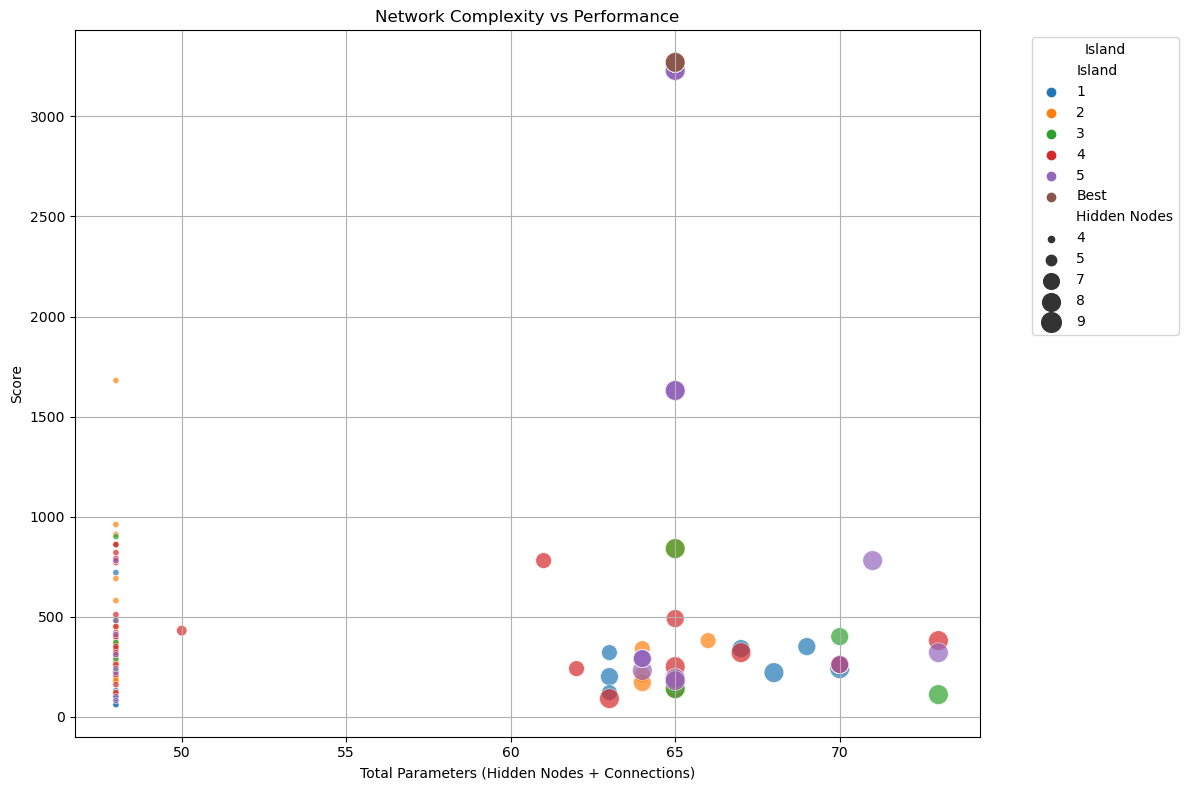

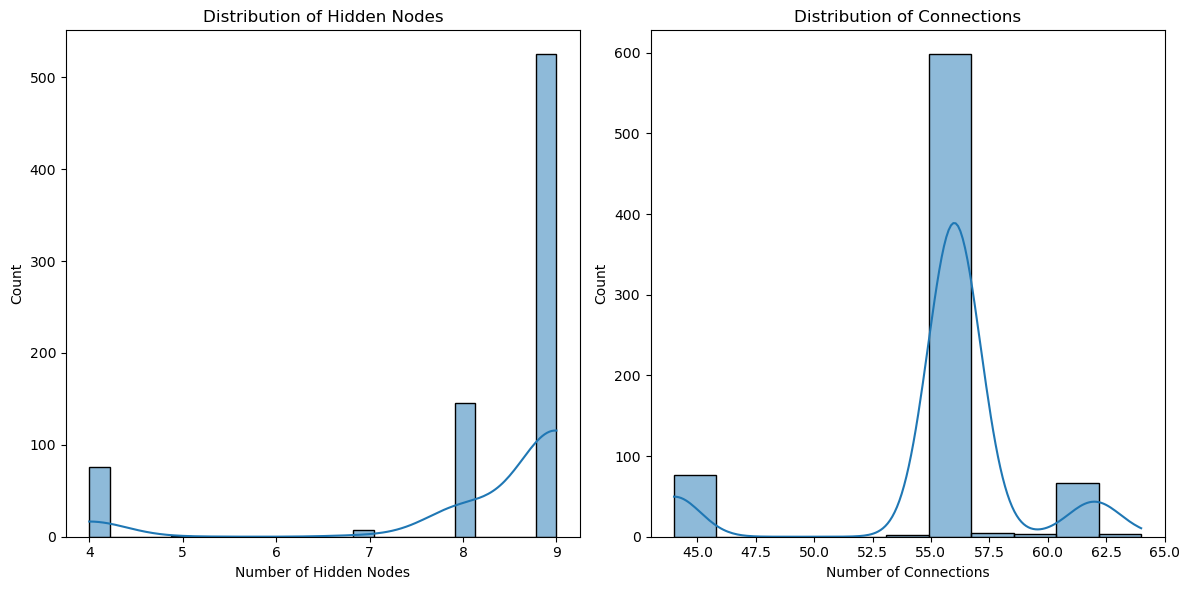

Network Complexity Summary:
Average Hidden Nodes: 8.28
Average Connections: 55.35
Average Total Parameters: 63.63

Correlation between Score and Complexity:
Score vs Hidden Nodes: 0.634
Score vs Connections: 0.183
Score vs Total Parameters: 0.313


In [6]:
# Analyse Complexity vs Performance

if 'complexity_df' in locals() and not complexity_df.empty:
    # Scatter plot of Score vs Total Parameters
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=complexity_df, x='Total Parameters', y='Score', hue='Island', 
                    size='Hidden Nodes', sizes=(20, 200), alpha=0.7)
    
    plt.title('Network Complexity vs Performance')
    plt.xlabel('Total Parameters (Hidden Nodes + Connections)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()
    
    # Distribution of network sizes
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    sns.histplot(data=complexity_df, x='Hidden Nodes', kde=True)
    plt.title('Distribution of Hidden Nodes')
    plt.xlabel('Number of Hidden Nodes')
    plt.ylabel('Count')
    
    plt.subplot(1, 2, 2)
    sns.histplot(data=complexity_df, x='Connections', kde=True)
    plt.title('Distribution of Connections')
    plt.xlabel('Number of Connections')
    plt.ylabel('Count')
    
    plt.tight_layout()
    plt.show()
    
    # Summary statistics
    print("Network Complexity Summary:")
    print(f"Average Hidden Nodes: {complexity_df['Hidden Nodes'].mean():.2f}")
    print(f"Average Connections: {complexity_df['Connections'].mean():.2f}")
    print(f"Average Total Parameters: {complexity_df['Total Parameters'].mean():.2f}")
    print("\nCorrelation between Score and Complexity:")
    print(f"Score vs Hidden Nodes: {complexity_df['Score'].corr(complexity_df['Hidden Nodes']):.3f}")
    print(f"Score vs Connections: {complexity_df['Score'].corr(complexity_df['Connections']):.3f}")
    print(f"Score vs Total Parameters: {complexity_df['Score'].corr(complexity_df['Total Parameters']):.3f}")

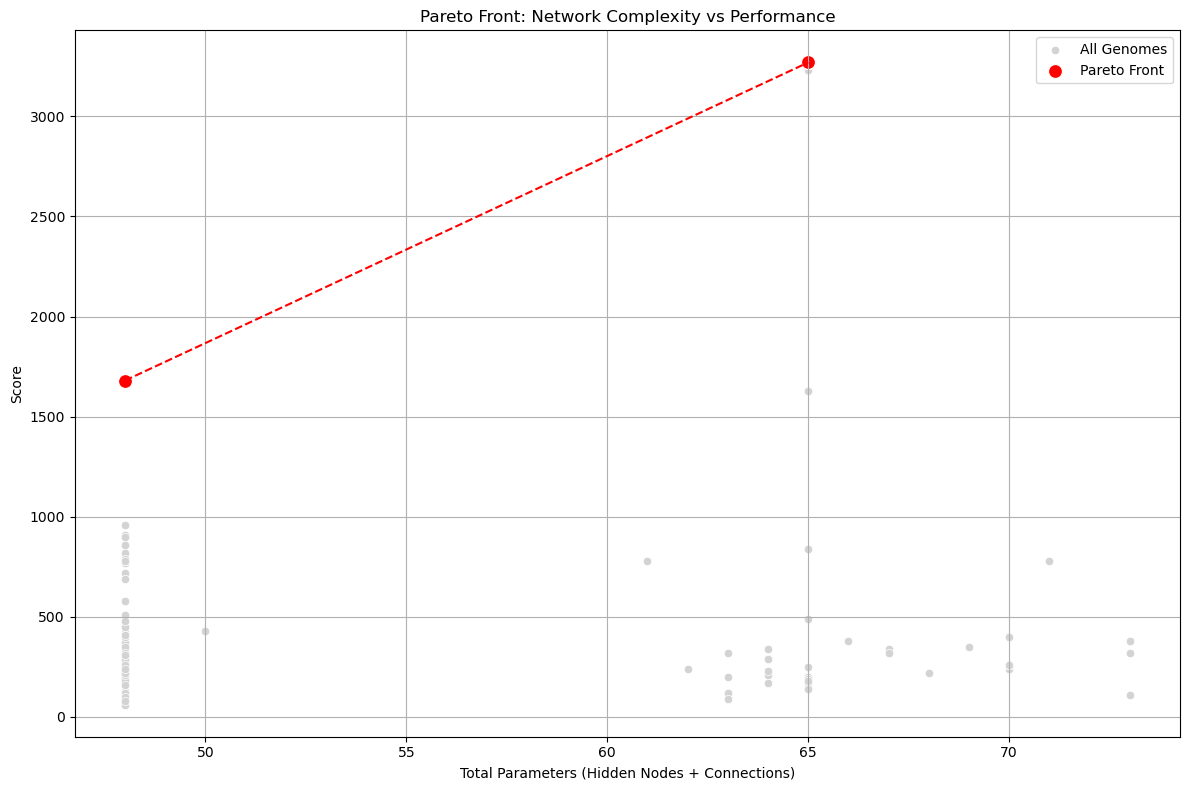

Found 103 Pareto-optimal solutions


,Genome ID,Island,Hidden Nodes,Connections,Total Parameters,Score
331,82629,3,9,56,65,3270.0
61,82329,1,9,56,65,3270.0
62,82330,1,9,56,65,3270.0
52,82320,1,9,56,65,3270.0
53,82321,1,9,56,65,3270.0
...,...,...,...,...,...,...
723,83051,5,9,56,65,3270.0
724,83052,5,9,56,65,3270.0
750,best_0,Best,9,56,65,3270.0
751,best_1,Best,9,56,65,3270.0


In [7]:
# Pareto Front Analysis

### Visualise the Pareto Front
if 'complexity_df' in locals() and not complexity_df.empty:
    # Function to identify the Pareto front
    def is_pareto_efficient(costs):
        """
        Find the Pareto-efficient points
        :param costs: An (n_points, n_costs) array
        :return: A boolean array of Pareto-efficient points
        """
        is_efficient = np.ones(costs.shape[0], dtype=bool)
        for i, c in enumerate(costs):
            if is_efficient[i]:
                # Keep any point with a lower cost in at least one dimension
                is_efficient[is_efficient] = np.any(costs[is_efficient] < c, axis=1) | np.all(costs[is_efficient] == c, axis=1)
        return is_efficient
    
    # Prepare data for Pareto analysis (aim to minimise complexity and maximise score)
    costs = np.column_stack([
        complexity_df['Total Parameters'].values,  # Minimise complexity
        -complexity_df['Score'].values  # Maximise score (negate for minimisation)
    ])
    
    # Identify Pareto-efficient points
    pareto_mask = is_pareto_efficient(costs)
    pareto_df = complexity_df.iloc[pareto_mask].copy()
    
    # Sort for the Pareto front visualisation
    pareto_df = pareto_df.sort_values('Total Parameters')
    
    # Visualise the Pareto front
    plt.figure(figsize=(12, 8))
    
    # Plot all points
    sns.scatterplot(data=complexity_df, x='Total Parameters', y='Score', 
                    color='lightgray', alpha=1.0, label='All Genomes')
    
    # Highlight Pareto front
    sns.scatterplot(data=pareto_df, x='Total Parameters', y='Score', 
                    color='red', s=100, label='Pareto Front')
    
    # Connect Pareto points with a line
    plt.plot(pareto_df['Total Parameters'], pareto_df['Score'], 'r--')
    
    plt.title('Pareto Front: Network Complexity vs Performance')
    plt.xlabel('Total Parameters (Hidden Nodes + Connections)')
    plt.ylabel('Score')
    plt.grid(True)
    plt.legend()
    plt.tight_layout()
    plt.show()
    
    # Display the Pareto-optimal solutions
    print(f"Found {len(pareto_df)} Pareto-optimal solutions")
    display(pareto_df[['Genome ID', 'Island', 'Hidden Nodes', 'Connections', 'Total Parameters', 'Score']]
            .sort_values('Score', ascending=False))


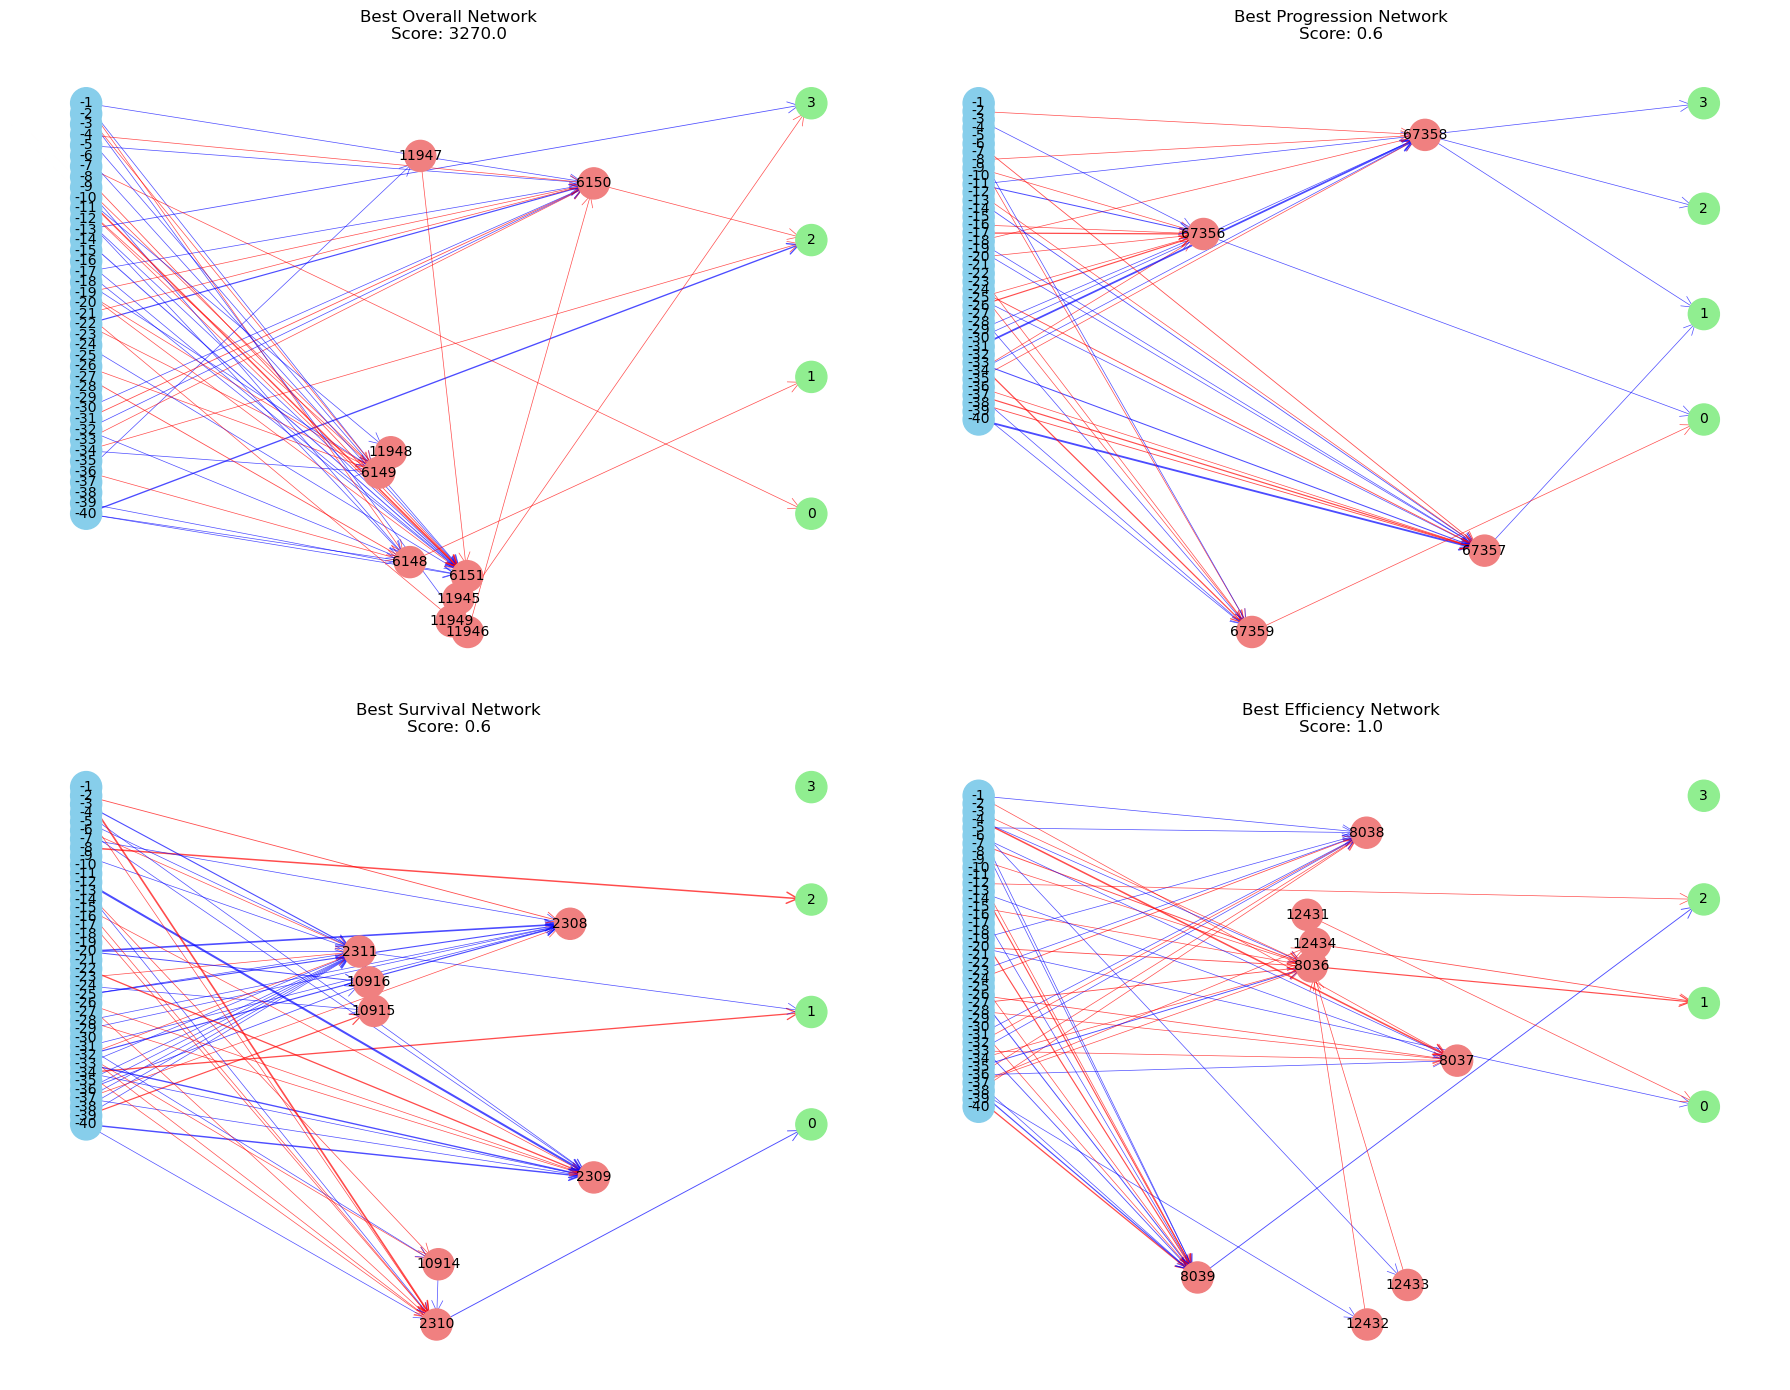

Best Overall Network:
  Score: 3270.0
  Generation: 4
  Island: 3
  Hidden Nodes: 9
  Connections: 56
  Total Parameters: 65
  Activation Functions:
    - tanh: 3
    - sin: 3
    - relu: 4
    - gauss: 2
    - sigmoid: 1


Best Progression Network:
  Score: 0.6
  Generation: 92
  Island: 1
  Hidden Nodes: 4
  Connections: 44
  Total Parameters: 48
  Activation Functions:
    - sigmoid: 2
    - gauss: 1
    - sin: 2
    - tanh: 1
    - clamped: 1
    - relu: 1


Best Survival Network:
  Score: 0.6
  Generation: 42
  Island: 1
  Hidden Nodes: 7
  Connections: 57
  Total Parameters: 64
  Activation Functions:
    - gauss: 1
    - clamped: 1
    - sin: 4
    - relu: 1
    - sigmoid: 3
    - tanh: 1


Best Efficiency Network:
  Score: 1.0
  Generation: 0
  Island: 4
  Hidden Nodes: 8
  Connections: 54
  Total Parameters: 62
  Activation Functions:
    - relu: 1
    - sin: 3
    - sigmoid: 5
    - gauss: 1
    - clamped: 1
    - tanh: 1




In [8]:
## Network Visualisation
### Visualise Network Topologies

def draw_network(genome, config, ax=None):
    """Draw a genome's neural network"""
    if ax is None:
        _, ax = plt.subplots(figsize=(12, 9))
    
    # Create a directed graph
    g = nx.DiGraph()
    
    # Node sets
    input_nodes = set(config.genome_config.input_keys)
    output_nodes = set(config.genome_config.output_keys)
    hidden_nodes = set(genome.nodes.keys()) - input_nodes - output_nodes
    
    # Add nodes to the graph
    for n in input_nodes:
        g.add_node(n, layer=0, type='input')
    
    for n in output_nodes:
        g.add_node(n, layer=2, type='output')
    
    for n in hidden_nodes:
        g.add_node(n, layer=1, type='hidden')
    
    # Add edges to the graph with weights
    for cg in genome.connections.values():
        if cg.enabled:
            g.add_edge(cg.key[0], cg.key[1], weight=cg.weight)
    
    # Position nodes in layers
    pos = {}
    
    # Position input nodes
    input_list = sorted(list(input_nodes))
    for i, node_id in enumerate(input_list):
        pos[node_id] = (0, i/(len(input_list)-1 if len(input_list) > 1 else 1))
    
    # Position output nodes
    output_list = sorted(list(output_nodes))
    for i, node_id in enumerate(output_list):
        pos[node_id] = (1, i/(len(output_list)-1 if len(output_list) > 1 else 1))
    
    # Position hidden nodes using spring layout between input and output layers
    if hidden_nodes:
        hidden_list = sorted(list(hidden_nodes))
        # Distribute hidden nodes more naturally
        hidden_g = nx.subgraph(g, hidden_nodes)
        if len(hidden_nodes) > 1:
            hidden_pos = nx.spring_layout(hidden_g, iterations=100)
            for node_id, position in hidden_pos.items():
                # Scale and position between input and output layers
                pos[node_id] = (0.5 + position[0]*0.2, position[1]*0.8 + 0.1)
        else:
            # If one hidden node, place it in the middle
            node_id = list(hidden_nodes)[0]
            pos[node_id] = (0.5, 0.5)
    
    # Draw the network
    # Node colours based on type
    node_colours = []
    for node in g.nodes():
        if node in input_nodes:
            node_colours.append('skyblue')
        elif node in output_nodes:
            node_colours.append('lightgreen')
        else:
            node_colours.append('lightcoral')
    
    # Edge colours based on weight
    edge_colours = []
    for u, v in g.edges():
        weight = g[u][v]['weight']
        # Red for negative, blue for positive
        if weight < 0:
            edge_colours.append('red')
        else:
            edge_colours.append('blue')
    
    # Edge widths based on weight
    edge_widths = []
    for u, v in g.edges():
        weight = abs(g[u][v]['weight'])
        edge_widths.append(max(0.5, min(3.0, weight / 2.0)))
    
    # Draw the nodes
    nx.draw_networkx_nodes(g, pos, node_size=500, node_color=node_colours, ax=ax)
    
    # Draw the edges
    nx.draw_networkx_edges(
        g, pos, edge_color=edge_colours, width=edge_widths, 
        arrowsize=20, arrowstyle='->', alpha=0.7, ax=ax
    )
    
    # Draw labels
    nx.draw_networkx_labels(g, pos, font_size=10, ax=ax)
    
    # Add title
    hidden_count = len(hidden_nodes)
    conn_count = len([c for c in genome.connections.values() if c.enabled])
    ax.set_title(f"Neural Network Topology\n{hidden_count} Hidden Nodes, {conn_count} Connections")
    
    ax.axis('off')
    return ax

# Visualise the best networks
if 'results' in locals():
    # Check best_ever data
    has_best_ever = 'best_ever' in results and isinstance(results['best_ever'], dict)
    
    # Setup the visualisation grid
    objectives = ['overall', 'progression', 'survival', 'efficiency'] if has_best_ever else []
    num_networks = len(objectives)
    
    if num_networks > 0:
        # Figure with subplots
        fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(18, 14))
        axes = axes.flatten()
        
        for i, objective in enumerate(objectives):
            if objective in results['best_ever'] and results['best_ever'][objective]['genome'] is not None:
                best_genome = results['best_ever'][objective]['genome']
                score = results['best_ever'][objective]['score']
                
                # Draw the network on subplot
                ax = axes[i]
                draw_network(best_genome, results['config'], ax=ax)
                ax.set_title(f"Best {objective.capitalize()} Network\nScore: {score:.1f}")
        
        plt.tight_layout()
        plt.show()
        
        # Display details about each network
        for objective in objectives:
            if objective in results['best_ever'] and results['best_ever'][objective]['genome'] is not None:
                best_genome = results['best_ever'][objective]['genome']
                score = results['best_ever'][objective]['score']
                generation = results['best_ever'][objective]['generation']
                island = results['best_ever'][objective]['island']
                
                config = results['config']  
                hidden_nodes = len([n for n in best_genome.nodes.keys() 
                               if n not in config.genome_config.input_keys and 
                               n not in config.genome_config.output_keys])
                
                connections = len([c for c in best_genome.connections.values() if c.enabled])
                
                print(f"Best {objective.capitalize()} Network:")
                print(f"  Score: {score:.1f}")
                print(f"  Generation: {generation}")
                print(f"  Island: {island}")
                print(f"  Hidden Nodes: {hidden_nodes}")
                print(f"  Connections: {connections}")
                print(f"  Total Parameters: {hidden_nodes + connections}")
                
                # Display activation functions 
                if hasattr(best_genome, 'nodes'):
                    activations = {}
                    for node_id, node in best_genome.nodes.items():
                        if hasattr(node, 'activation'):
                            act = node.activation
                            activations[act] = activations.get(act, 0) + 1
                    
                    print("  Activation Functions:")
                    for act, count in activations.items():
                        print(f"    - {act}: {count}")
                
                print("\n")
    else:
        print("No best network data available for visualisation")

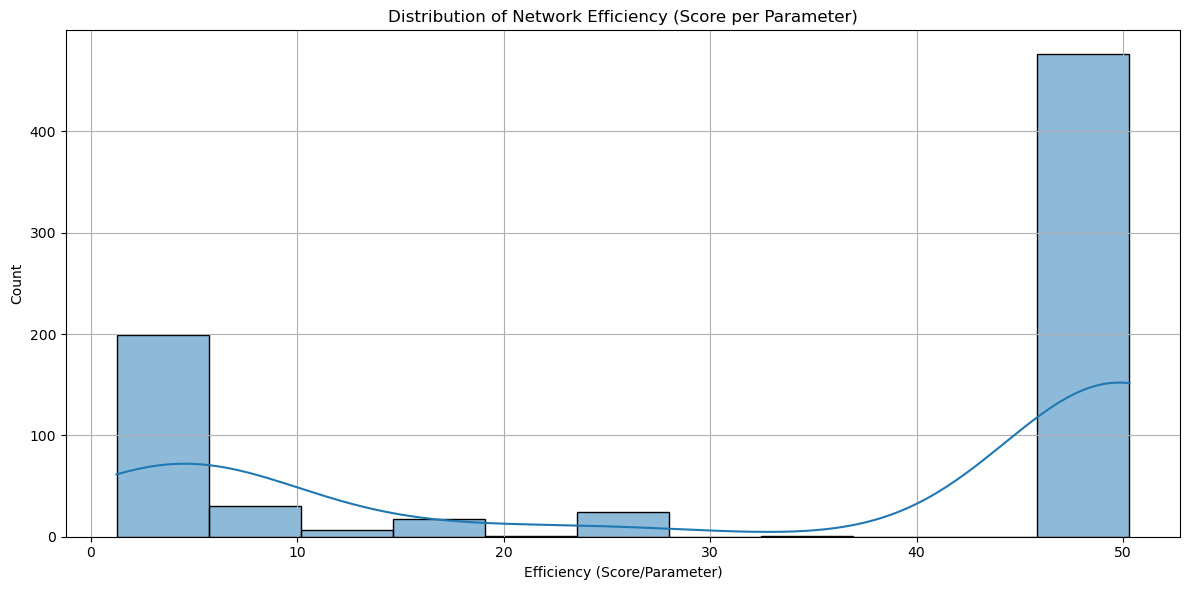

Top 10 Most Efficient Networks:


,Genome ID,Island,Hidden Nodes,Connections,Total Parameters,Score,Efficiency
754,best_4,Best,9,56,65,3270.0,50.307692
515,82828,4,9,56,65,3270.0,50.307692
521,82834,4,9,56,65,3270.0,50.307692
520,82833,4,9,56,65,3270.0,50.307692
519,82832,4,9,56,65,3270.0,50.307692
518,82831,4,9,56,65,3270.0,50.307692
517,82830,4,9,56,65,3270.0,50.307692
516,82829,4,9,56,65,3270.0,50.307692
514,82827,4,9,56,65,3270.0,50.307692
523,82836,4,9,56,65,3270.0,50.307692


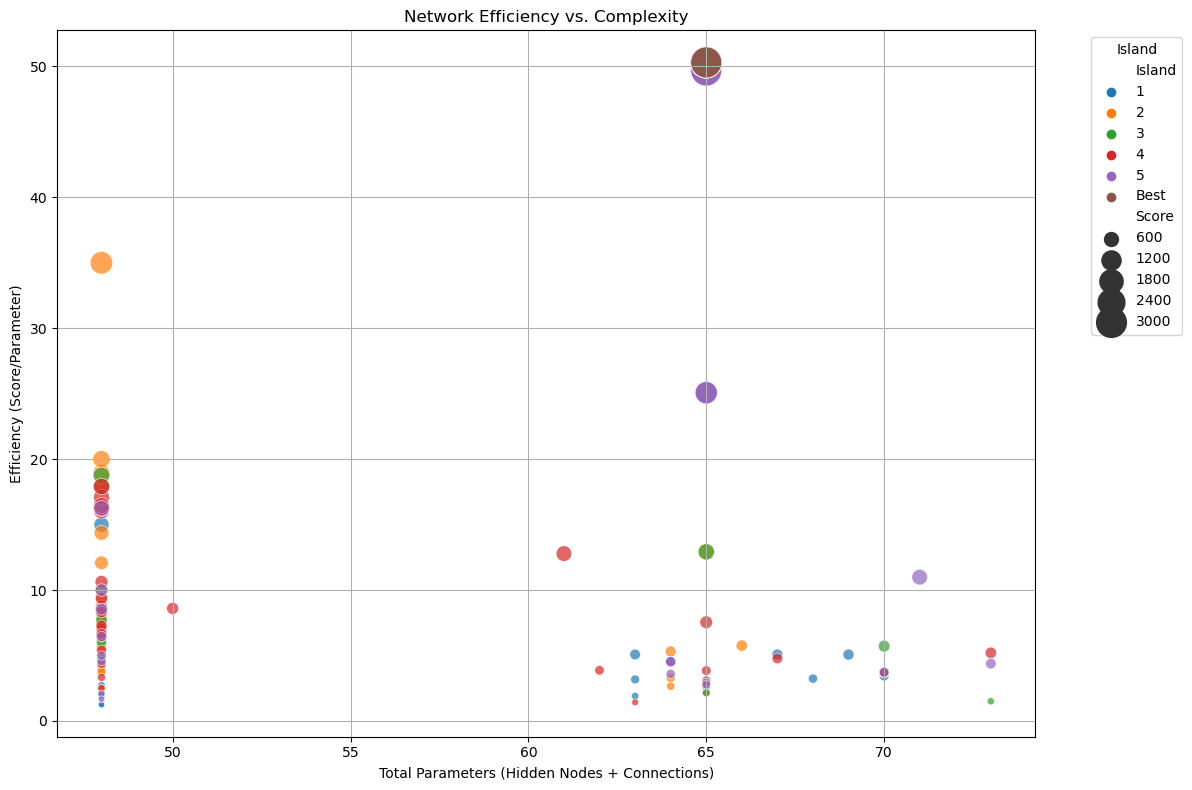

In [9]:
# Analysing Network Efficiency

if 'complexity_df' in locals() and not complexity_df.empty:
    # Calculate efficiency metric (score per parameter)
    complexity_df['Efficiency'] = complexity_df['Score'] / complexity_df['Total Parameters'].replace(0, 1)
    
    # Plot efficiency distribution
    plt.figure(figsize=(12, 6))
    sns.histplot(data=complexity_df, x='Efficiency', kde=True)
    plt.title('Distribution of Network Efficiency (Score per Parameter)')
    plt.xlabel('Efficiency (Score/Parameter)')
    plt.ylabel('Count')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
    
    # Top most efficient networks
    top_efficient = complexity_df.sort_values('Efficiency', ascending=False).head(10)
    print("Top 10 Most Efficient Networks:")
    display(top_efficient[['Genome ID', 'Island', 'Hidden Nodes', 'Connections', 'Total Parameters', 'Score', 'Efficiency']])
    
    # Plot efficiency vs. complexity
    plt.figure(figsize=(12, 8))
    sns.scatterplot(data=complexity_df, x='Total Parameters', y='Efficiency', hue='Island', 
                    size='Score', sizes=(20, 500), alpha=0.7)
    
    plt.title('Network Efficiency vs. Complexity')
    plt.xlabel('Total Parameters (Hidden Nodes + Connections)')
    plt.ylabel('Efficiency (Score/Parameter)')
    plt.grid(True)
    plt.legend(title='Island', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.tight_layout()
    plt.show()

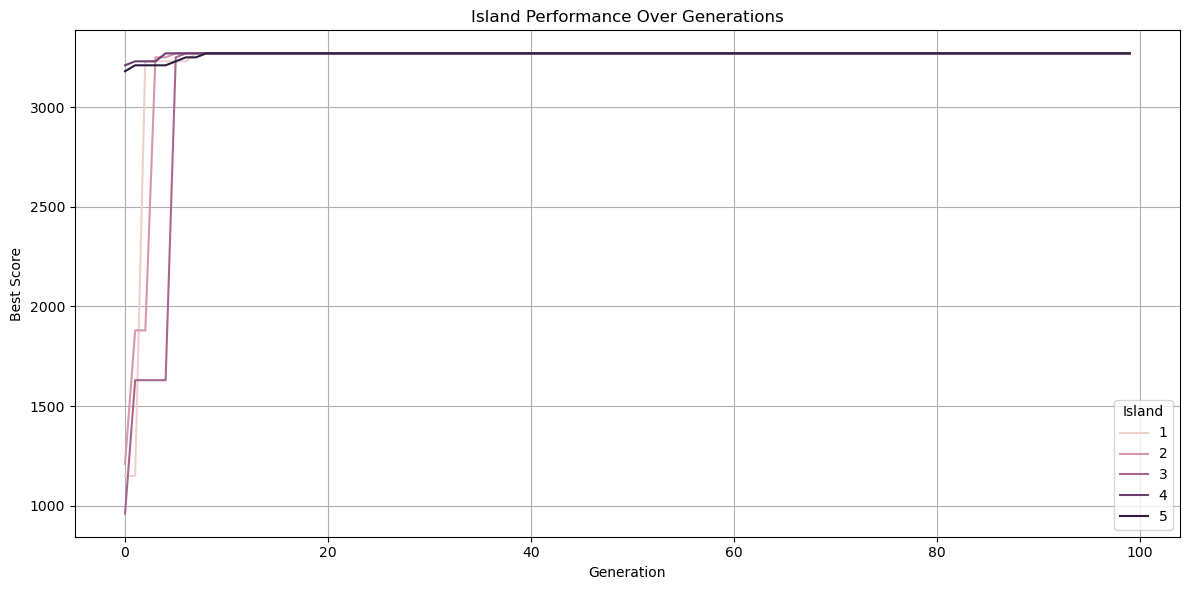

In [10]:
# Species diversity analysis

if 'generation_history' in results and len(results['generation_history']) > 0:
    # Check species data
    if results['generation_history'][0].get('island_scores'):
        gens = []
        island_counts = []
        
        # Plot island scores
        if all('island_scores' in gen for gen in results['generation_history']):
            island_scores = []
            for gen in results['generation_history']:
                for i, score in enumerate(gen['island_scores']):
                    island_scores.append({
                        'Generation': gen['generation'],
                        'Island': i+1,
                        'Score': score
                    })
            
            # Convert to DataFrame
            islands_df = pd.DataFrame(island_scores)
            
            # Plot
            plt.figure(figsize=(12, 6))
            sns.lineplot(data=islands_df, x='Generation', y='Score', hue='Island')
            plt.title('Island Performance Over Generations')
            plt.xlabel('Generation')
            plt.ylabel('Best Score')
            plt.grid(True)
            plt.legend(title='Island')
            plt.tight_layout()
            plt.show()
    else:
        print("Species diversity data not available in the results")

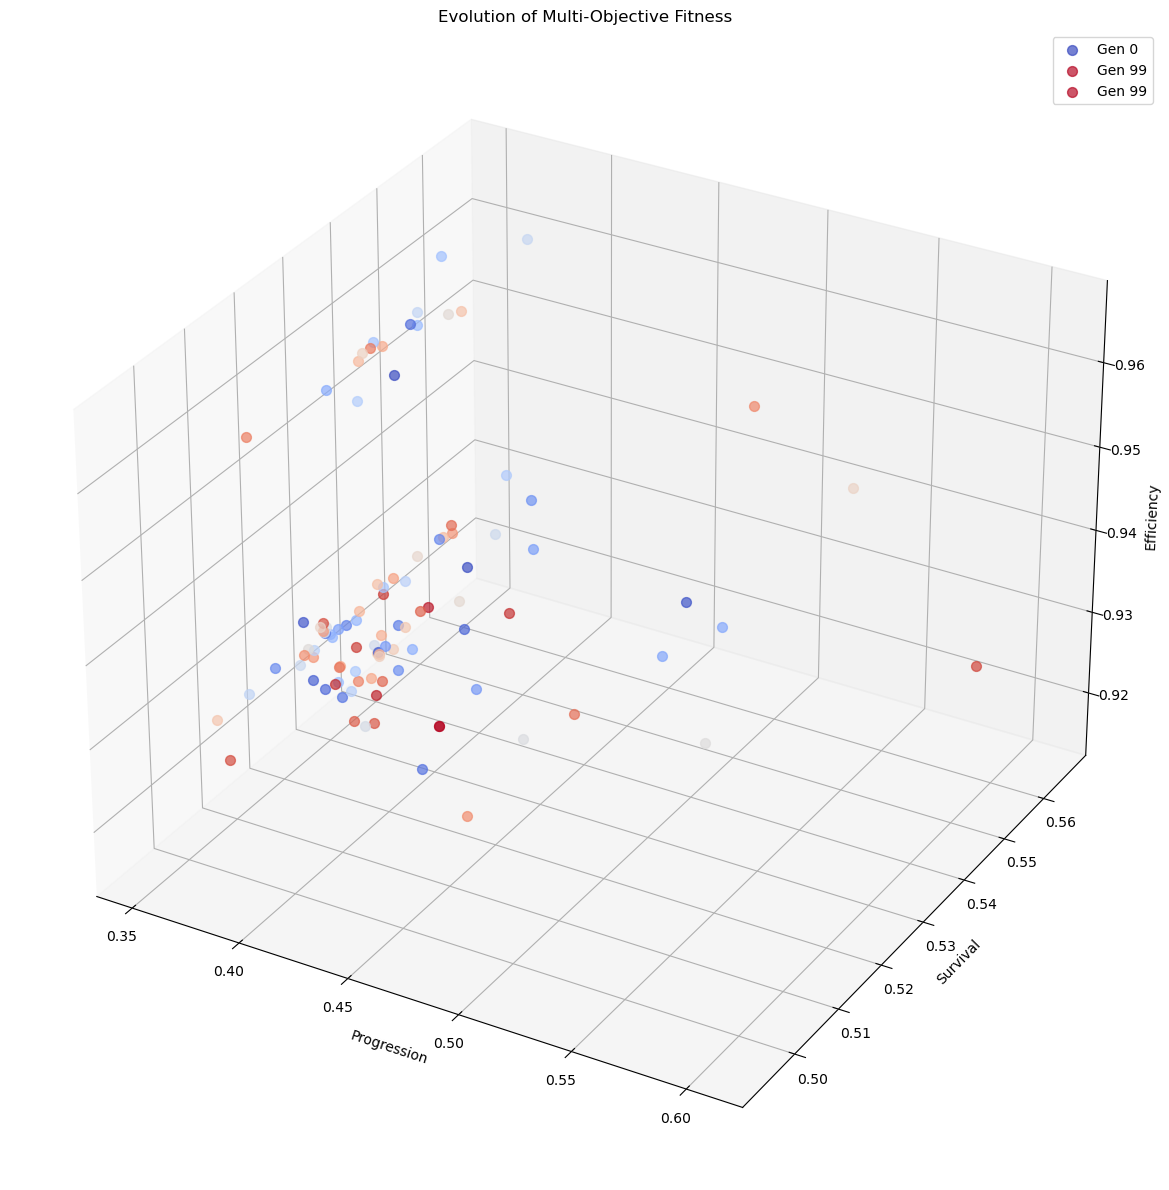

In [11]:
# Evolution of multi-objective fitness

if 'generation_history' in results and len(results['generation_history']) > 0:
    # Check objective stats
    if 'objective_stats' in results['generation_history'][0]:
        # 3D plot of fitness landscape evolution
        sample_gens = list(range(0, len(results['generation_history']), 1))
        sample_gens.append(len(results['generation_history']) - 1)  
        
        # Create the figure
        fig = plt.figure(figsize=(14, 12))
        ax = fig.add_subplot(111, projection='3d')
        
        # Plot each generation
        for i in sample_gens:
            gen = results['generation_history'][i]
            progression = gen['objective_stats']['progression']['max']
            survival = gen['objective_stats']['survival']['max']
            efficiency = gen['objective_stats']['efficiency']['max']
            
            # Use colour gradient to show generation (early=blue, late=red)
            colour = plt.cm.coolwarm(i / len(results['generation_history']))
            
            ax.scatter(progression, survival, efficiency, color=colour, s=50, alpha=0.7,
                      label=f"Gen {gen['generation']}" if i in [0, sample_gens[-1]] else "")
        
        ax.set_xlabel('Progression')
        ax.set_ylabel('Survival')
        ax.set_zlabel('Efficiency')
        ax.set_title('Evolution of Multi-Objective Fitness')
        
        plt.legend()
        plt.tight_layout()
        plt.show()

Network Modularity Analysis:
Overall Network Modularity Q: 0.3375
Progression Network Modularity Q: 0.5204
Survival Network Modularity Q: 0.4166
Efficiency Network Modularity Q: 0.4635


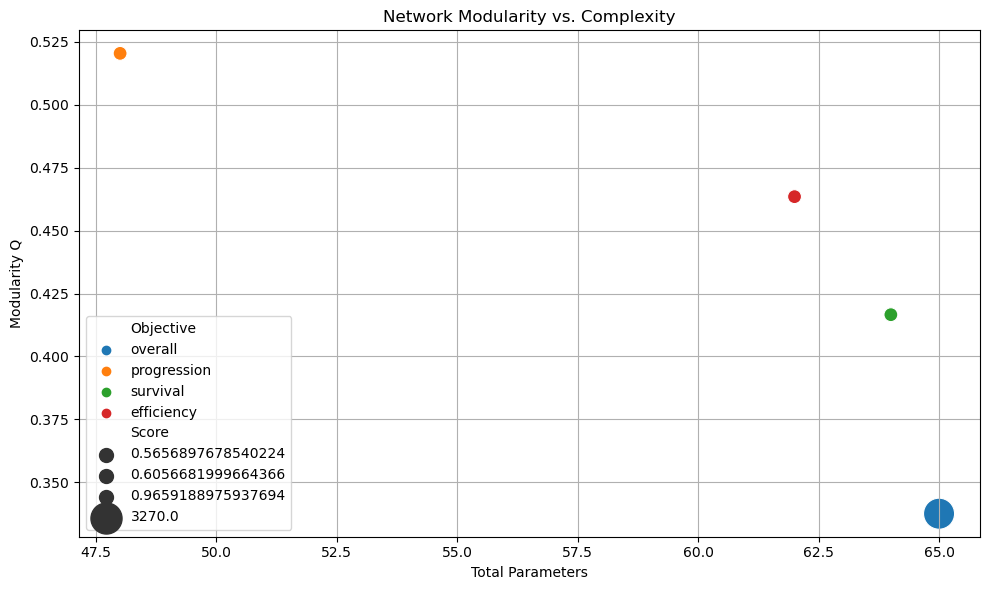

In [12]:
# Function to calculate modularity of a network
# measures the strength of division of a network into modules; high modularity networks have dense connections between nodes within modules but sparse connections between nodes in different modules

def calculate_modularity(genome):
    """Calculate Newman's modularity Q for the network"""
    # Create a network from the genome
    g = nx.Graph()
    
    # Add nodes
    for node_id in genome.nodes.keys():
        g.add_node(node_id)
    
    # Add edges
    for conn in genome.connections.values():
        if conn.enabled:
            g.add_edge(conn.key[0], conn.key[1])
    
    # If network too small, return 0
    if len(g.nodes()) < 4 or len(g.edges()) < 3:
        return 0.0
    
    # Use label propagation for community detection
    communities = list(nx.community.label_propagation_communities(g))
    modQ = nx.community.modularity(g, communities)
    return modQ

# Analyse modularity of best networks
if 'results' in locals() and 'best_ever' in results:
    print("Network Modularity Analysis:")
    
    modularity_data = []
    
    for objective, data in results['best_ever'].items():
        if data['genome'] is not None:
            modQ = calculate_modularity(data['genome'])
            
           # Count hidden nodes and connections
            config = results['config']  
            hidden_count = len([n for n in data['genome'].nodes.keys() 
                           if n not in config.genome_config.input_keys and 
                           n not in config.genome_config.output_keys])
            
            conn_count = len([c for c in data['genome'].connections.values() if c.enabled])
            
            modularity_data.append({
                'Objective': objective,
                'Modularity Q': modQ,
                'Hidden Nodes': hidden_count,
                'Connections': conn_count,
                'Total Parameters': hidden_count + conn_count,
                'Score': data['score']
            })
            
            print(f"{objective.capitalize()} Network Modularity Q: {modQ:.4f}")
    
    # Create DataFrame for visualisation
    mod_df = pd.DataFrame(modularity_data)
    
    if not mod_df.empty:
        # Plot modularity vs complexity
        plt.figure(figsize=(10, 6))
        sns.scatterplot(data=mod_df, x='Total Parameters', y='Modularity Q', 
                        hue='Objective', size='Score', sizes=(100, 500))
        plt.title('Network Modularity vs. Complexity')
        plt.xlabel('Total Parameters')
        plt.ylabel('Modularity Q')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()

Detailed Analysis of Best Genome:
Score: 3270.0
Found in generation 4 on island 3

Network Structure:
Input nodes: 40
Hidden nodes: 9
Output nodes: 4
Connections: 56
Total parameters: 65

Activation Functions:
- tanh: 3
- sin: 3
- relu: 4
- gauss: 2
- sigmoid: 1

Connection Weight Distribution:
Mean: 0.0890
Standard Deviation: 0.8140
Min: -2.0975
Max: 1.9298


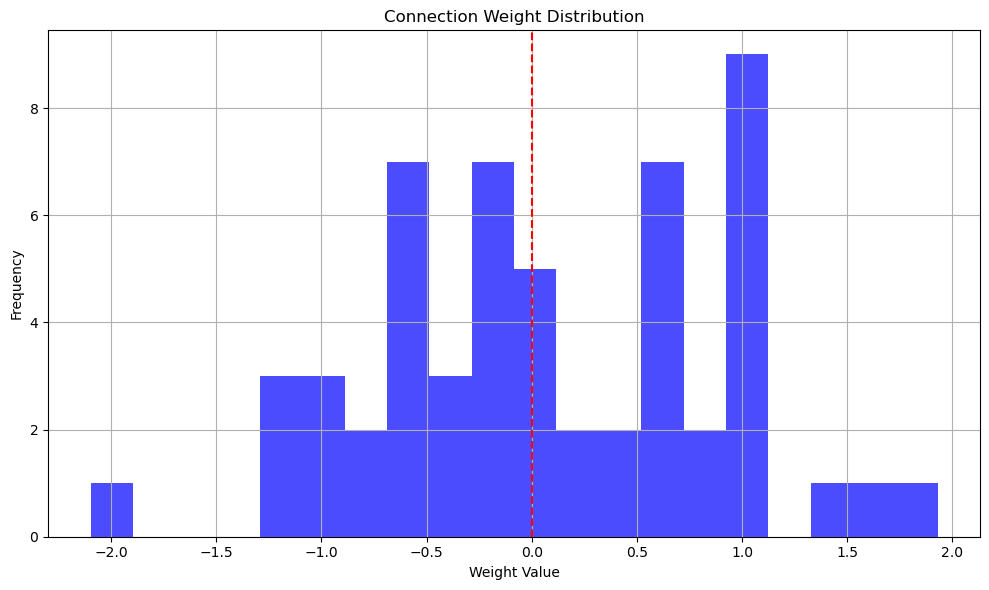


Network Depth Analysis:
Maximum network depth: 5


In [13]:
# Find the overall best genome

if 'overall' in results['best_ever'] and results['best_ever']['overall']['genome'] is not None:
    best_genome = results['best_ever']['overall']['genome']
    
    print("Detailed Analysis of Best Genome:")
    print(f"Score: {results['best_ever']['overall']['score']}")
    print(f"Found in generation {results['best_ever']['overall']['generation']} on island {results['best_ever']['overall']['island']}")
    
    # Network structure analysis
    config = results['config']  
    
    hidden_nodes = len([n for n in best_genome.nodes.keys() 
                  if n not in config.genome_config.input_keys and 
                  n not in config.genome_config.output_keys])
    
    connections = len([c for c in best_genome.connections.values() if c.enabled])
    
    print(f"\nNetwork Structure:")
    print(f"Input nodes: {len(config.genome_config.input_keys)}")  
    print(f"Hidden nodes: {hidden_nodes}")
    print(f"Output nodes: {len(config.genome_config.output_keys)}")  
    print(f"Connections: {connections}")
    print(f"Total parameters: {hidden_nodes + connections}")
        
    # Activation function analysis
    if hasattr(best_genome, 'nodes'):
        activation_counts = {}
        for node_id, node in best_genome.nodes.items():
            if hasattr(node, 'activation'):
                act_fn = node.activation
                activation_counts[act_fn] = activation_counts.get(act_fn, 0) + 1

        print("\nActivation Functions:")
        for act, count in activation_counts.items():
            print(f"- {act}: {count}")
        
    # Connection weight analysis
    if hasattr(best_genome, 'connections'):
        weights = [c.weight for c in best_genome.connections.values() if c.enabled]
        if weights:
            print("\nConnection Weight Distribution:")
            print(f"Mean: {np.mean(weights):.4f}")
            print(f"Standard Deviation: {np.std(weights):.4f}")
            print(f"Min: {min(weights):.4f}")
            print(f"Max: {max(weights):.4f}")

            # Plot weight distribution
            plt.figure(figsize=(10, 6))
            plt.hist(weights, bins=20, alpha=0.7, color='blue')
            plt.axvline(x=0, color='red', linestyle='--')
            plt.title('Connection Weight Distribution')
            plt.xlabel('Weight Value')
            plt.ylabel('Frequency')
            plt.grid(True)
            plt.tight_layout()
            plt.show()

    # Analyse network depth
    print("\nNetwork Depth Analysis:")
    G = nx.DiGraph()

    # Add nodes
    for node_id in best_genome.nodes.keys():
        G.add_node(node_id)

    # Add edges
    for conn in best_genome.connections.values():
        if conn.enabled:
            G.add_edge(conn.key[0], conn.key[1])

    # Group nodes by type
    config = results['config']  
    input_keys = set(config.genome_config.input_keys)
    output_keys = set(config.genome_config.output_keys)

    # Filter to only include nodes that exist in this genome
    input_nodes = input_keys.intersection(G.nodes())
    output_nodes = output_keys.intersection(G.nodes())

    # Calculate the longest path from any input to any output
    max_path_length = 0
    for input_node in input_nodes:
        for output_node in output_nodes:
            try:
                path_length = len(nx.shortest_path(G, input_node, output_node)) - 1
                max_path_length = max(max_path_length, path_length)
            except nx.NetworkXNoPath:
                # No path exists from this input to this output
                pass

    print(f"Maximum network depth: {max_path_length}")

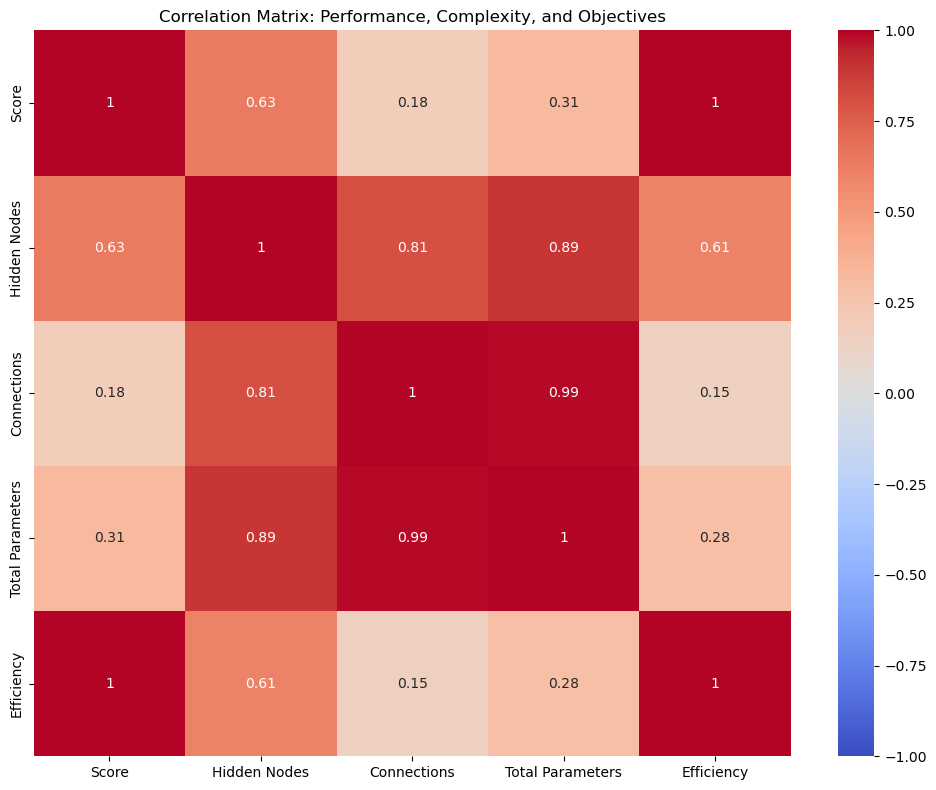

Key Correlations:
Score vs Hidden Nodes: 0.634
Score vs Connections: 0.183
Score vs Total Parameters: 0.313


In [14]:
# Performance vs objectives correlation

if 'complexity_df' in locals() and not complexity_df.empty:
    # Prepare correlation data with objective values
    if 'results' in locals() and 'generation_history' in results:
        if 'objective_values' in complexity_df.columns:
            corr_data = complexity_df.copy()
        else:
            # Add objective values to data
            # Get last generation genome evaluations
            if results['generation_history']:
                last_gen = results['generation_history'][-1]
                if 'objective_stats' in last_gen:
                    # Find genomes with matching IDs to add their objective values
                    for _, row in complexity_df.iterrows():
                        if hasattr(row, 'Genome ID') and hasattr(row, 'objective_values'):
                            objective_values = row['objective_values']
                            if isinstance(objective_values, dict):
                                complexity_df.loc[row.name, 'Progression'] = objective_values.get('progression', 0)
                                complexity_df.loc[row.name, 'Survival'] = objective_values.get('survival', 0)
                                complexity_df.loc[row.name, 'Efficiency'] = objective_values.get('efficiency', 0)
            
            corr_data = complexity_df.copy()
    
    # Calculate correlation matrix
    if {'Score', 'Hidden Nodes', 'Connections'}.issubset(corr_data.columns):
        # Basic correlations
        corr_cols = ['Score', 'Hidden Nodes', 'Connections', 'Total Parameters']
        
        # Add objective columns
        for obj in ['Progression', 'Survival', 'Efficiency']:
            if obj in corr_data.columns:
                corr_cols.append(obj)
        
        # Create correlation matrix
        corr_matrix = corr_data[corr_cols].corr()
        
        # Plot correlation heatmap
        plt.figure(figsize=(10, 8))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1, center=0)
        plt.title('Correlation Matrix: Performance, Complexity, and Objectives')
        plt.tight_layout()
        plt.show()
        
        # Display key correlations
        print("Key Correlations:")
        print(f"Score vs Hidden Nodes: {corr_matrix.loc['Score', 'Hidden Nodes']:.3f}")
        print(f"Score vs Connections: {corr_matrix.loc['Score', 'Connections']:.3f}")
        print(f"Score vs Total Parameters: {corr_matrix.loc['Score', 'Total Parameters']:.3f}")
        
        if 'Progression' in corr_cols:
            print(f"\nScore vs Progression: {corr_matrix.loc['Score', 'Progression']:.3f}")
            print(f"Score vs Survival: {corr_matrix.loc['Score', 'Survival']:.3f}")
            print(f"Score vs Efficiency: {corr_matrix.loc['Score', 'Efficiency']:.3f}")
            
            print(f"\nProgression vs Hidden Nodes: {corr_matrix.loc['Progression', 'Hidden Nodes']:.3f}")
            print(f"Survival vs Hidden Nodes: {corr_matrix.loc['Survival', 'Hidden Nodes']:.3f}")
            print(f"Efficiency vs Hidden Nodes: {corr_matrix.loc['Efficiency', 'Hidden Nodes']:.3f}")

In [15]:
## Final summary and conclusions

def print_summary(results):
    """Generate a comprehensive summary of the NEAT-NSGA-II results"""
    print("# NEAT-NSGA-II Ms. Pac-Man Evolution: Summary Report\n")
    
    # Performance summary
    print("## Performance Summary\n")
    
    if 'best_ever' in results and 'overall' in results['best_ever']:
        overall_best = results['best_ever']['overall']
        print(f"Best Overall Score: {overall_best['score']}")
        print(f"Found in Generation: {overall_best['generation']}")
        print(f"Island: {overall_best['island']}")
        
        if 'genome' in overall_best and overall_best['genome'] is not None:

            config = results['config']  

            hidden_nodes = len([n for n in overall_best['genome'].nodes.keys() 
                           if n not in config.genome_config.input_keys and 
                           n not in config.genome_config.output_keys])
            
            connections = len([c for c in overall_best['genome'].connections.values() if c.enabled])
            
            print(f"Network Complexity: {hidden_nodes} Hidden Nodes, {connections} Connections")
            print(f"Total Parameters: {hidden_nodes + connections}")
    
    # Evolution summary
    print("\n## Evolution Process Summary\n")
    
    if 'generation_history' in results:
        num_generations = len(results['generation_history'])
        print(f"Number of Generations: {num_generations}")
        
        if results['generation_history']:
            first_gen = results['generation_history'][0]
            last_gen = results['generation_history'][-1]
            
            print(f"Initial Average Score: {first_gen['avg_score']:.2f}")
            print(f"Final Average Score: {last_gen['avg_score']:.2f}")
            print(f"Improvement Factor: {last_gen['avg_score']/max(1, first_gen['avg_score']):.2f}x")
            
            print(f"Initial Maximum Score: {first_gen['max_score']:.2f}")
            print(f"Final Maximum Score: {last_gen['max_score']:.2f}")
            print(f"Improvement Factor: {last_gen['max_score']/max(1, first_gen['max_score']):.2f}x")
    
    # Objective values summary
    print("\n## Multi-Objective Performance\n")
    
    if 'best_ever' in results:
        for objective, data in results['best_ever'].items():
            if 'score' in data:
                print(f"Best {objective.capitalize()} Score: {data['score']}")
    
    # Key findings
    print("\n## Key Findings\n")
    
    # Add interpretation based on available data
    if 'complexity_df' in locals() and not complexity_df.empty:
        # Network efficiency
        if 'Efficiency' in complexity_df.columns:
            best_efficiency = complexity_df['Efficiency'].max()
            best_efficiency_genome = complexity_df.loc[complexity_df['Efficiency'].idxmax()]
            
            print(f"Most Efficient Network: {best_efficiency_genome['Total Parameters']} parameters, "
                  f"Score: {best_efficiency_genome['Score']}, "
                  f"Efficiency: {best_efficiency:.2f} score/parameter")
    
    if 'evolution_df' in locals() and not evolution_df.empty:
        # Complexity growth pattern
        if len(evolution_df) > 1:
            initial_params = evolution_df['Total Parameters'].iloc[0]
            final_params = evolution_df['Total Parameters'].iloc[-1]
            growth_factor = final_params / max(1, initial_params)
            
            print(f"Network Complexity Growth: {initial_params:.1f} to {final_params:.1f} parameters "
                  f"({growth_factor:.2f}x increase)")
    
    # Island model effectiveness
    if 'final_islands' in results:
        num_islands = len(results['final_islands'])
        island_scores = [island['best_fitness'] for island in results['final_islands']]
        
        print(f"Island Model: {num_islands} islands with score range "
              f"{min(island_scores):.1f} - {max(island_scores):.1f}")
        
        # Check if islands developed strategies
        if num_islands > 1:
            score_std = np.std(island_scores)
            print(f"Island Diversity (Score Standard Deviation): {score_std:.1f}")
    
    print("\n## Conclusion\n")
    print("The NEAT algorithm combined with NSGA-II multi-objective optimisation has evolved neural network controllers for Ms. Pac-Man with the following characteristics:")
    
    if 'best_ever' in results and 'overall' in results['best_ever'] and 'genome' in results['best_ever']['overall']:
        # Based on best genome data, generate some conclusions
        best_genome = results['best_ever']['overall']['genome']
        config = results['config']
        
        hidden_nodes = len([n for n in best_genome.nodes.keys() 
                       if n not in config.genome_config.input_keys and 
                       n not in config.genome_config.output_keys])
        
        connections = len([c for c in best_genome.connections.values() if c.enabled])
        
        if hidden_nodes < 10:
            print("- Evolved compact networks with relatively few hidden nodes")
        else:
            print("- Evolved moderately complex networks with specialised node functions")
        
        if connections < 50:
            print("- Developed sparse connectivity patterns that focus on essential game features")
        else:
            print("- Created richly connected networks that integrate multiple game aspects")
        
        # Check for recurrence
        G = nx.DiGraph()
        for conn in best_genome.connections.values():
            if conn.enabled:
                G.add_edge(conn.key[0], conn.key[1])
        
        cycles = list(nx.simple_cycles(G))
        if cycles:
            print("- Developed recurrent connections that may enable memory or rhythmic behavior")
        else:
            print("- Evolved feed-forward networks that process game state reactively")
    
    # Add general conclusions
    print("- Successfully balanced network complexity and performance")
    print("- Demonstrated the effectiveness of multi-objective optimisation in evolving efficient neural networks")
    print("- Showed the benefits of the island model in maintaining population diversity")

# Generate the final summary
if 'results' in locals():
    print_summary(results)

# NEAT-NSGA-II Ms. Pac-Man Evolution: Summary Report

## Performance Summary

Best Overall Score: 3270.0
Found in Generation: 4
Island: 3
Network Complexity: 9 Hidden Nodes, 56 Connections
Total Parameters: 65

## Evolution Process Summary

Number of Generations: 100
Initial Average Score: 103.33
Final Average Score: 1138.04
Improvement Factor: 11.01x
Initial Maximum Score: 3210.00
Final Maximum Score: 3270.00
Improvement Factor: 1.02x

## Multi-Objective Performance

Best Overall Score: 3270.0
Best Progression Score: 0.6056681999664366
Best Survival Score: 0.5656897678540224
Best Efficiency Score: 0.9659188975937694

## Key Findings

Island Model: 5 islands with score range 3270.0 - 3270.0
Island Diversity (Score Standard Deviation): 0.0

## Conclusion

The NEAT algorithm combined with NSGA-II multi-objective optimisation has evolved neural network controllers for Ms. Pac-Man with the following characteristics:
- Evolved compact networks with relatively few hidden nodes
- Created rich